In [1]:
import pandas as pd
df = pd.read_table('Example1.DAT', sep=",") 
print(df.head())
df.describe()


   Tree  Apple  Size  AppleID  Time  Diam
0     1      1     7        1     1  2.90
1     1      1     7        1     2  2.90
2     1      1     7        1     3  2.90
3     1      1     7        1     4  2.93
4     1      1     7        1     5  2.94


,Tree,Apple,Size,AppleID,Time,Diam
count,480.000000,480.000000,480.0,480.000000,480.000000,480.000000
mean,5.025000,13.437500,7.0,114.062500,3.500000,2.750250
std,2.956787,7.383065,0.0,73.452868,1.709607,0.706318
min,1.000000,1.000000,7.0,1.000000,1.000000,0.000000
25%,2.750000,8.000000,7.0,50.750000,2.000000,2.840000
50%,5.000000,14.000000,7.0,106.000000,3.500000,2.900000
75%,7.250000,20.000000,7.0,175.500000,5.000000,2.990000
max,10.000000,25.000000,7.0,248.000000,6.000000,3.470000


In [2]:
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,15))
plt.show()

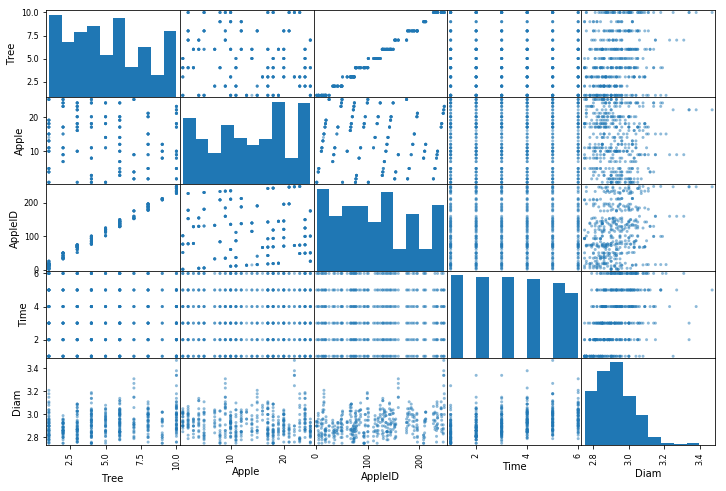

C:\Users\aless\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


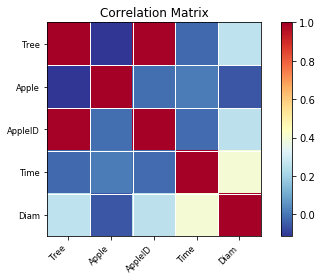

In [3]:
# there appear to be an issue in the diameter measure. remove all diam = 0
df = df[df.Diam != 0]

# size does not seem very informative, let's ignore it for now
attributes = ['Tree','Apple','AppleID','Time','Diam']
pd.plotting.scatter_matrix(df[attributes], figsize=(12, 8))
plt.show()

import statsmodels.graphics.api as smg
p = smg.plot_corr(df[attributes].corr(),xnames = attributes)


In [4]:
# it seems that appleID and Tree are very correlated, this collinearity could result in bad/instable parameter estimates
# also, diam seems log-normally distributed, perhaps a data transformation will be required

import statsmodels.api as sm
import statsmodels.formula.api as smf

#-----------------------------------------------------------------------------------------------
# Define model with no random effects
# Yijk = b0ij) + b1ij*Xk + eijk   B0 = mean(boij)  and B1 = mean(b1ij)
md1 = smf.mixedlm("Diam ~ Time", df, re_formula ='1', groups = 'Tree')      # model with random intercept for every tree

#-----------------------------------------------------------------------------------------------
# Define mixed model with random intercept
# Yijk = (Bo + b0ij) + (B1 + b1ij)Xk + eijk
md1 = smf.mixedlm("Diam ~ Time", df, re_formula ='1', groups = 'Tree')      # model with random intercept for every tree

#-----------------------------------------------------------------------------------------------
# Define mixed model with random slope and random intercept
# Yijk = (Bo + b0ij) + (B1 + b1ij)Xk + eijk
md2 = smf.mixedlm("Diam ~ Time", df, re_formula ='1 + Tree', groups = 'Tree') 
md = md2.fit(method='powell')   # method = 'lbfgs'  'cg'  'powell'  lbfgs 
# some warning from the fit, apparently converging close to the boundaries of the parameter space

print(md.summary())

              Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     Diam    
No. Observations:     451         Method:                 REML    
No. Groups:           10          Scale:                  0.0091  
Min. group size:      18          Likelihood:             402.8610
Max. group size:      66          Converged:              Yes     
Mean group size:      45.1                                        
------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept               2.815    0.010 295.462 0.000  2.796  2.834
Time                    0.027    0.003  10.070 0.000  0.022  0.032
Intercept RE            0.000                                     
Intercept RE x Tree RE -0.000                                     
Tree RE                 0.000    0.000                            



C:\Users\aless\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\aless\Anaconda3\lib\site-packages\statsmodels\base\model.py:1029: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


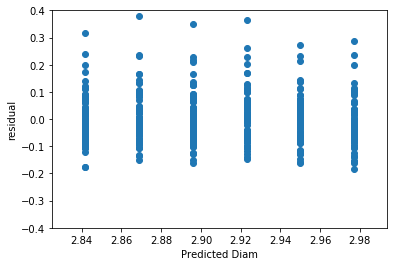

In [5]:
# check for homoskedasticity, ie non-normally distributed residuals
def plot_res(df, md):
    predicted_Diam = md.predict(df)
    residuals = md.resid
    #plt.scatter(df["Time"],residuals), plt.xlabel("Time")
    plt.scatter(predicted_Diam, residuals), plt.xlabel("Predicted Diam")
    plt.ylabel("residual"), plt.ylim((-.4,.4))
    plt.show()

plot_res(df, md)

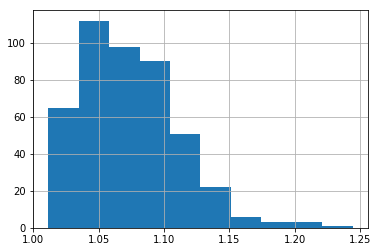

              Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     LT_Diam 
No. Observations:     451         Method:                 REML    
No. Groups:           10          Scale:                  0.0010  
Min. group size:      18          Likelihood:             894.1561
Max. group size:      66          Converged:              Yes     
Mean group size:      45.1                                        
------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept               1.035    0.003 344.804 0.000  1.029  1.041
Time                    0.009    0.001  10.275 0.000  0.007  0.011
Intercept RE            0.000                                     
Intercept RE x Tree RE -0.000                                     
Tree RE                 0.000    0.000                            



C:\Users\aless\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\aless\Anaconda3\lib\site-packages\statsmodels\base\model.py:1029: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


In [8]:
# residuals don't seem far from normally distributed, but not fully ok.
# this is what we expected from the visual inspection already. Diam was not normally distributed
import numpy as np

s = pd.Series(np.log(df.Diam))
s.hist()
plt.show()

df1 = pd.concat([df, s], axis = 1)
df1.columns.values[-1] = 'LT_Diam'

md1 = smf.mixedlm("LT_Diam ~ Time", df1, re_formula ='1 + Tree', groups = 'Tree') 
md = md1.fit(method = 'powell')
print(md.summary())

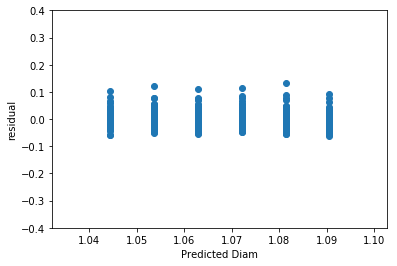

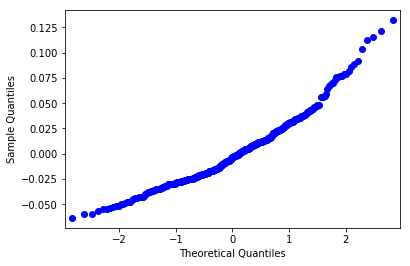

In [28]:
plot_res(df1, md) 
sm.qqplot(md.resid)
plt.show()
# now the residuals look more normal (no heteroskedasticity), with constant variance
# the qq plot, which shows the quantiles of the data samples against those of thew normal distribution, suggests that residuals are approximatly normal (could be better though... :)


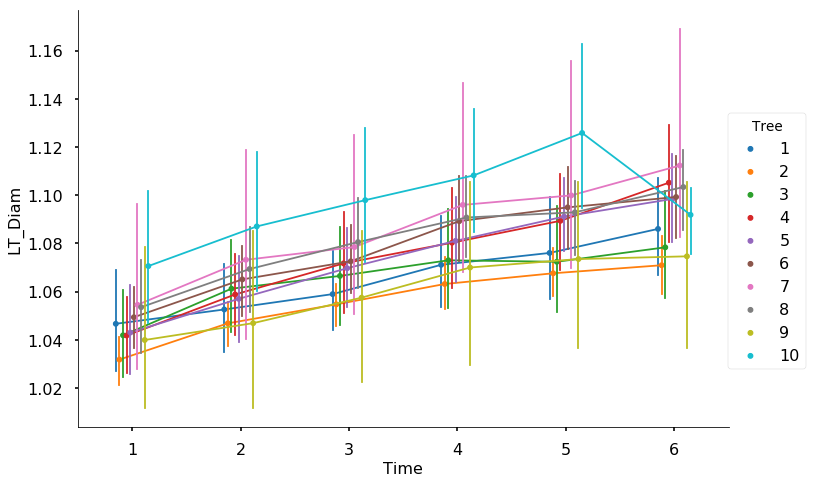

In [69]:
import seaborn as sns
ax = sns.factorplot(x="Time", y="LT_Diam", hue="Tree",
                    data=df1, dodge=0.3,
                    size=7, aspect = 1.5)
sns.set_context("poster", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16,'lines.linewidth': 1, 'lines.markersize': 10})   
